# Requirements

In [21]:
# !pip install experta

# Reading the Data

In [22]:
import pandas as pd
import pickle as pkl
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import re
from sklearn.tree import export_text

In [23]:
dataset = "Fraud-Detection-Transactions-Dataset/synthetic_fraud_dataset.csv"
df = pd.read_csv('datasets/'+dataset)
print(len(df))

50000


In [24]:
target_col = 'Fraud_Label'
print(df.shape)
df.columns = df.columns.str.strip()
#drop: Transaction_ID, User_ID
df.drop(['Transaction_ID', 'User_ID'], axis=1, inplace=True)
# Convert to datetime if not already
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Extract hour
df['Hour'] = df['Timestamp'].dt.hour

# Drop original Timestamp column
df = df.drop(columns=['Timestamp'])
df.head()

(50000, 21)


,Transaction_Amount,Transaction_Type,Account_Balance,Device_Type,Location,Merchant_Category,IP_Address_Flag,Previous_Fraudulent_Activity,Daily_Transaction_Count,Avg_Transaction_Amount_7d,Failed_Transaction_Count_7d,Card_Type,Card_Age,Transaction_Distance,Authentication_Method,Risk_Score,Is_Weekend,Fraud_Label,Hour
0,39.79,POS,93213.17,Laptop,Sydney,Travel,0,0,7,437.63,3,Amex,65,883.17,Biometric,0.8494,0,0,19
1,1.19,Bank Transfer,75725.25,Mobile,New York,Clothing,0,0,13,478.76,4,Mastercard,186,2203.36,Password,0.0959,0,1,4
2,28.96,Online,1588.96,Tablet,Mumbai,Restaurants,0,0,14,50.01,4,Visa,226,1909.29,Biometric,0.8400,0,1,15
3,254.32,ATM Withdrawal,76807.20,Tablet,New York,Clothing,0,0,8,182.48,4,Visa,76,1311.86,OTP,0.7935,0,1,0
4,31.28,POS,92354.66,Mobile,Mumbai,Electronics,0,1,14,328.69,4,Mastercard,140,966.98,Password,0.3819,1,1,23


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Transaction_Amount            50000 non-null  float64
 1   Transaction_Type              50000 non-null  object 
 2   Account_Balance               50000 non-null  float64
 3   Device_Type                   50000 non-null  object 
 4   Location                      50000 non-null  object 
 5   Merchant_Category             50000 non-null  object 
 6   IP_Address_Flag               50000 non-null  int64  
 7   Previous_Fraudulent_Activity  50000 non-null  int64  
 8   Daily_Transaction_Count       50000 non-null  int64  
 9   Avg_Transaction_Amount_7d     50000 non-null  float64
 10  Failed_Transaction_Count_7d   50000 non-null  int64  
 11  Card_Type                     50000 non-null  object 
 12  Card_Age                      50000 non-null  int64  
 13  T

In [26]:
df.isnull().sum().sum()

0

# Label Encoding

In [27]:
print(f"{target_col}: {df[target_col].value_counts()}")

for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = pd.factorize(df[col])[0]
        print(f"Column '{col}' has {df[col].nunique()} unique values.")

class_names = ['Not Fraud', 'Fraud']
# Define label mapping
label_map = {0: "Not Fraud", 1: "Fraud"}

Fraud_Label: Fraud_Label
0    33933
1    16067
Name: count, dtype: int64
Column 'Transaction_Type' has 4 unique values.
Column 'Device_Type' has 3 unique values.
Column 'Location' has 5 unique values.
Column 'Merchant_Category' has 5 unique values.
Column 'Card_Type' has 4 unique values.
Column 'Authentication_Method' has 4 unique values.


In [28]:
df[target_col].value_counts()

Fraud_Label
0    33933
1    16067
Name: count, dtype: int64

# Normalization

In [29]:
# Normalize the data
feature_cols = df.columns[df.columns != target_col]
mx = MinMaxScaler()
df[feature_cols] = mx.fit_transform(df[feature_cols])


# Rules

In [30]:
X = df.drop(target_col, axis=1)
y = df[target_col]

# 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

clf = DecisionTreeClassifier(
    criterion="entropy",
    max_depth=4,              # Try values: None, 3, 5, 10, etc.
    min_samples_split=100,     # Prevent overfitting
    min_samples_leaf=50,       # Minimum samples in a leaf
    min_impurity_decrease=0.01,
    # max_features="sqrt",
    random_state=42
)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)


depth = clf.get_depth()
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Tree Depth: {depth} | Number of Leaves: {clf.get_n_leaves()}")

Test Accuracy: 1.0000
Tree Depth: 2 | Number of Leaves: 3


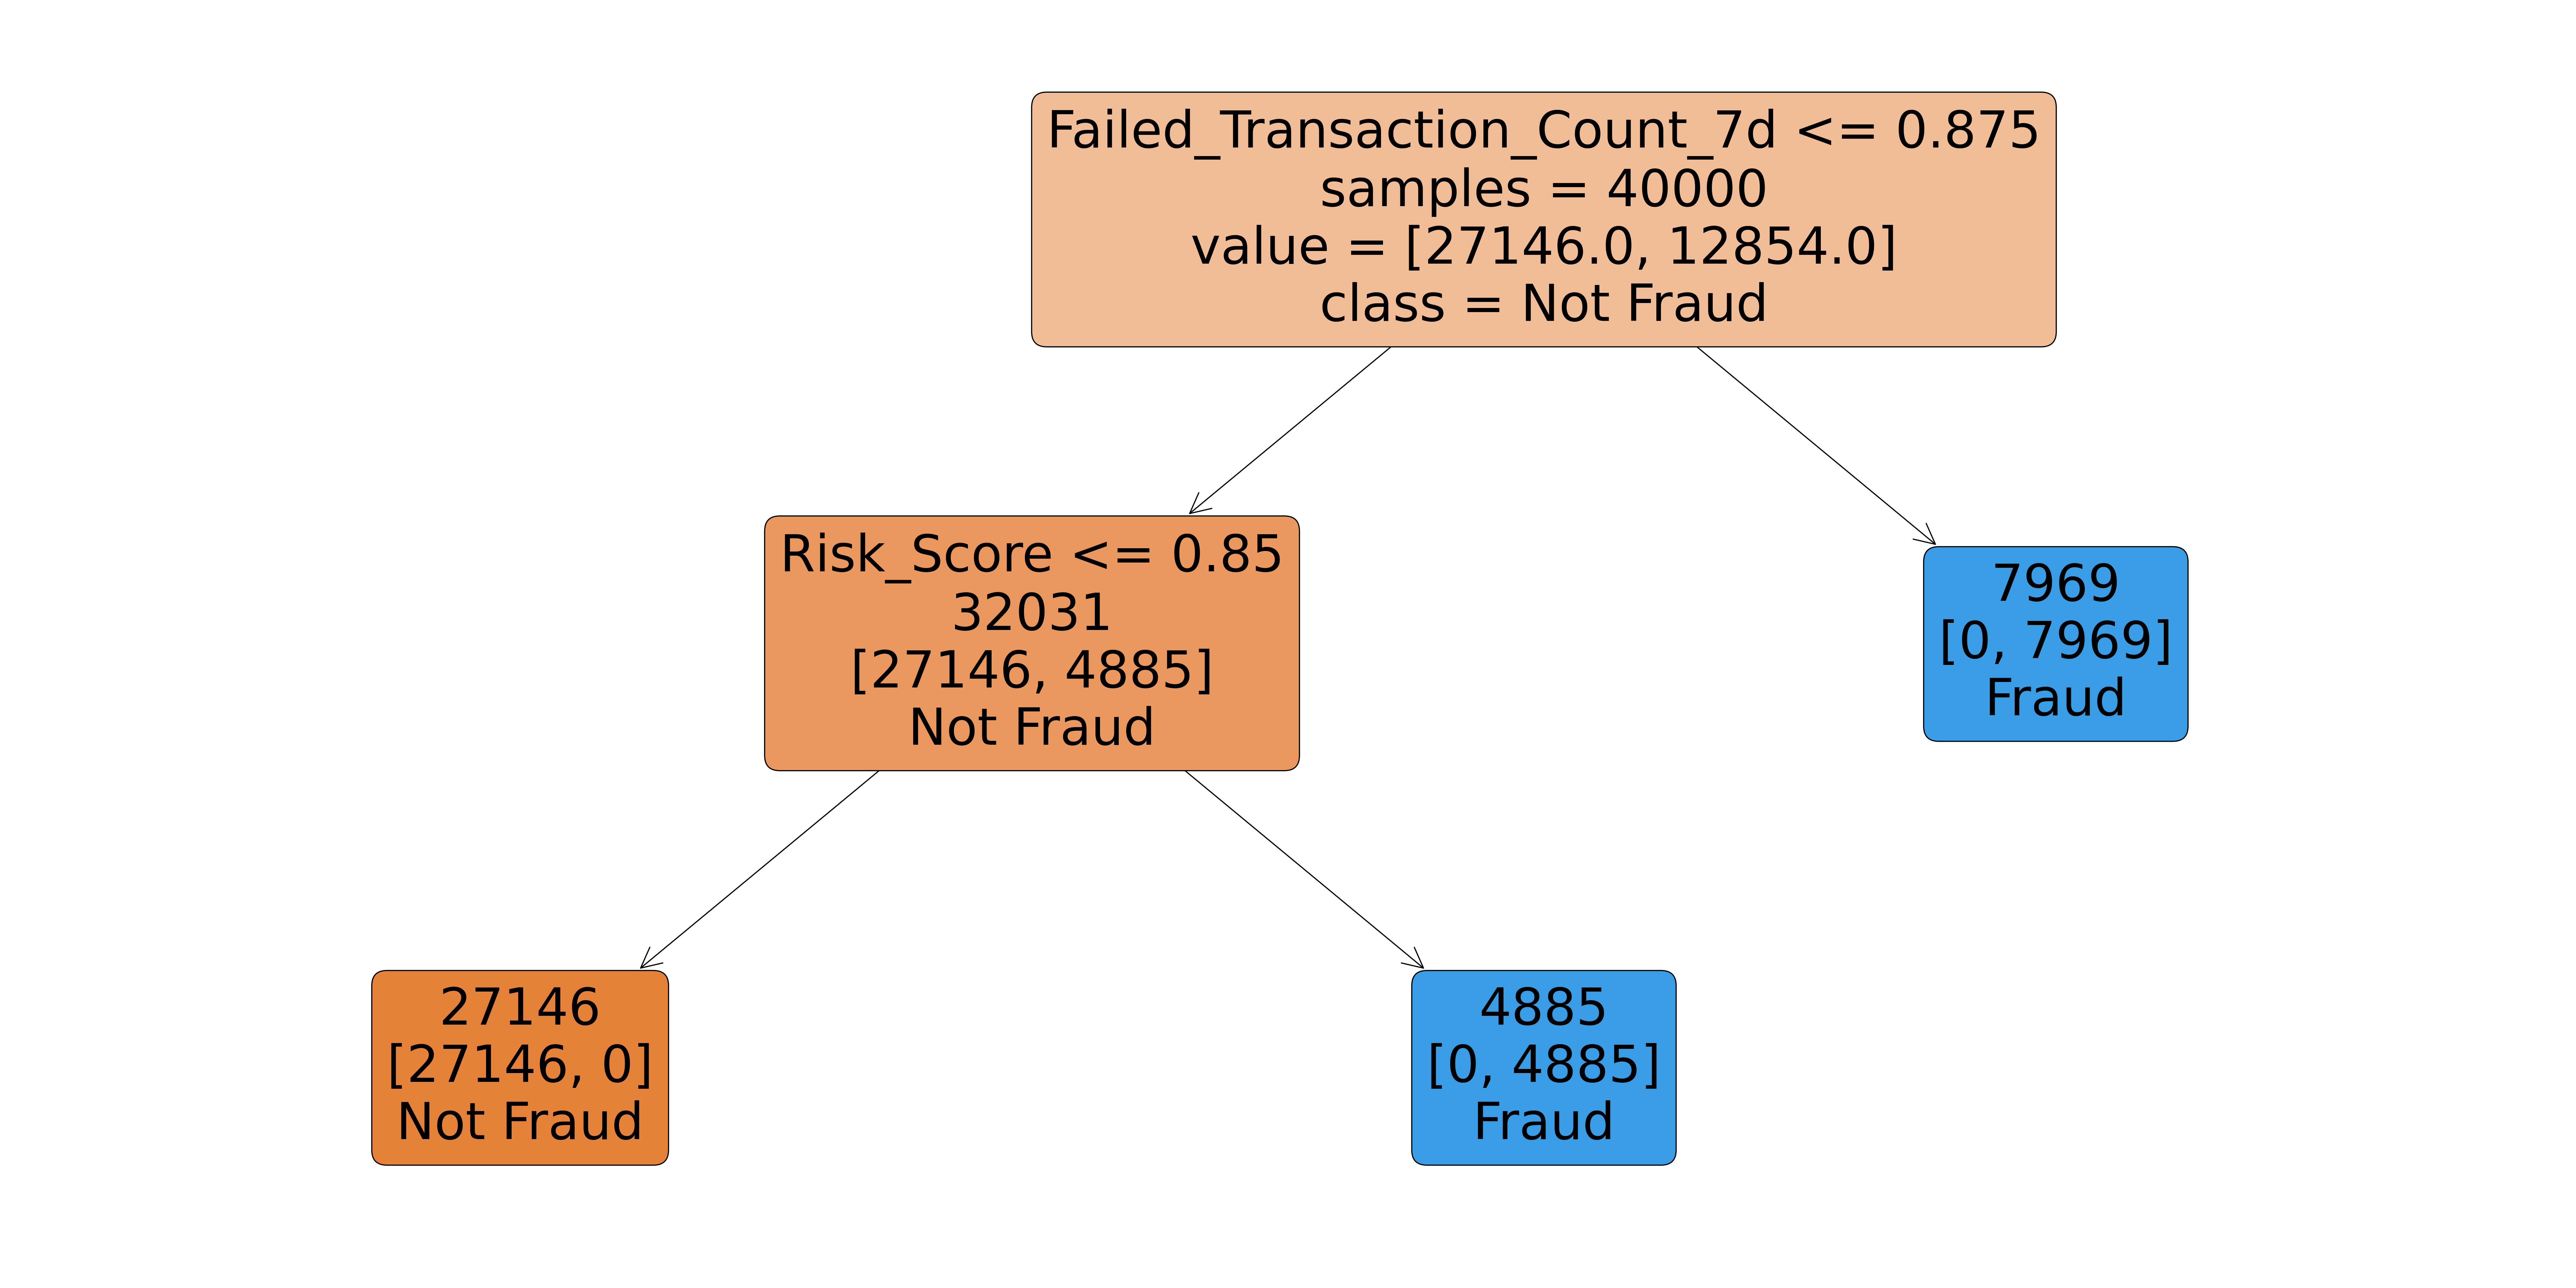

In [31]:
plt.figure(figsize=(40, 20), dpi=300)
plot_tree(
    clf,
    feature_names=X.columns,
    class_names=class_names,
    filled=True,
    rounded=True,
    impurity=False,
    label="root"
)
plt.savefig("Trees/decision_tree_rule_fraud.png", bbox_inches="tight")
# plt.close()


In [32]:
tree_rules = export_text(clf, feature_names=list(X.columns), max_depth=depth+5, decimals=5)
# print(rules)
# Write rules to a file
with open("Rules/fraud_rules.txt", "w") as f:
    f.write(tree_rules)

In [33]:
# Parse and convert
rules = []
rule_count = 0
stack = []

for line in tree_rules.split("\n"):
    indent_level = line.count("|   ")
    line = line.strip()

    # Remove tree symbols
    line = re.sub(r"\|--- ", "", line)
    line = line.replace("|   ", "")

    if line.startswith("class:"):
        class_val = int(float(line.split(":")[1].strip()))
        class_label = label_map[class_val]
        # Build final rule from stack
        conditions = stack[:indent_level]
        condition_str = ", ".join(conditions)
        rule_code = f"""    @Rule(Fact({condition_str}))
    def rule_{rule_count}(self):
        # print(f"Rule {rule_count}: Fraud Status: {class_label}")
        self.prediction = {0 if class_label == "Not Fraud" else 1}\n"""
        rules.append(rule_code)
        rule_count += 1
    elif "<=" in line or ">" in line:
        op = "<=" if " <= " in line else ">"
        feature, op_val = line.split(op)
        val = float(op_val.strip())
        stack = stack[:indent_level] + [f"{feature.strip()}=P(lambda x: x {op} {val})"]

# Output rules
print("""from experta import *\n\nclass FraudExpert(KnowledgeEngine):
    def __init__(self):
        super().__init__()
        self.prediction = None\n""")
for r in rules:
    print(r)


from experta import *

class FraudExpert(KnowledgeEngine):
    def __init__(self):
        super().__init__()
        self.prediction = None

    @Rule(Fact(Failed_Transaction_Count_7d=P(lambda x: x <= 0.875), Risk_Score=P(lambda x: x <= 0.85004)))
    def rule_0(self):
        # print(f"Rule 0: Fraud Status: Not Fraud")
        self.prediction = 0

    @Rule(Fact(Failed_Transaction_Count_7d=P(lambda x: x <= 0.875), Risk_Score=P(lambda x: x > 0.85004)))
    def rule_1(self):
        # print(f"Rule 1: Fraud Status: Fraud")
        self.prediction = 1

    @Rule(Fact(Failed_Transaction_Count_7d=P(lambda x: x > 0.875)))
    def rule_2(self):
        # print(f"Rule 2: Fraud Status: Fraud")
        self.prediction = 1



# Knowledge Base

In [34]:
from experta import *

class FraudExpert(KnowledgeEngine):
    def __init__(self):
        super().__init__()
        self.prediction = None

    @Rule(Fact(Failed_Transaction_Count_7d=P(lambda x: x <= 0.875), Risk_Score=P(lambda x: x <= 0.85004)))
    def rule_0(self):
        # print(f"Rule 0: Fraud Status: Not Fraud")
        self.prediction = 0

    @Rule(Fact(Failed_Transaction_Count_7d=P(lambda x: x <= 0.875), Risk_Score=P(lambda x: x > 0.85004)))
    def rule_1(self):
        # print(f"Rule 1: Fraud Status: Fraud")
        self.prediction = 1

    @Rule(Fact(Failed_Transaction_Count_7d=P(lambda x: x > 0.875)))
    def rule_2(self):
        # print(f"Rule 2: Fraud Status: Fraud")
        self.prediction = 1

# Inference

In [35]:
# Testing on one example

user_input = {
    "Transaction_Amount":              39.79,
    "Transaction_Type":                0,
    "Account_Balance":                 93213.17,
    "Device_Type":                     2,
    "Location":                        2,
    "Merchant_Category":               1,
    "IP_Address_Flag":                 0,
    "Previous_Fraudulent_Activity":    0,
    "Daily_Transaction_Count":         7,
    "Avg_Transaction_Amount_7d":       437.63,
    "Failed_Transaction_Count_7d":     3,
    "Card_Type":                       0,
    "Card_Age":                        65,
    "Transaction_Distance":            883.17,
    "Authentication_Method":           1,
    "Risk_Score":                      0.8494,
    "Is_Weekend":                      0,
    "Hour":                            5
}
# Convert to DataFrame to transform
input_df = pd.DataFrame([user_input])
normalized_input = mx.transform(input_df)[0]  # 1D array
normalized_fact = dict(zip(df.columns, normalized_input))


# normalized_fact = {
# "Transaction_Amount":              0.008594,
# "Transaction_Type":                0.000000,
# "Account_Balance":                 0.737284,
# "Device_Type":                     0.500000,
# "Location":                        0.500000,
# "Merchant_Category":               0.250000,
# "IP_Address_Flag":                 0.000000,
# "Previous_Fraudulent_Activity":    0.000000,
# "Daily_Transaction_Count":         1.000000,
# "Avg_Transaction_Amount_7d":       0.220714,
# "Failed_Transaction_Count_7d":     0.750000,
# "Card_Type":                       0.000000,
# "Card_Age":                        0.676471,
# "Transaction_Distance":            0.839782,
# "Authentication_Method":           0.333333,
# "Risk_Score":                      0.642464,
# "Is_Weekend":                      0.000000,
# "Hour":                            0.217391
# }

engine = FraudExpert()
engine.reset()
engine.declare(Fact(**normalized_fact))
engine.run()
print(engine.prediction)


0


In [36]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report, precision_score, recall_score

y_pred_rule = []

for i, row in X_test.iterrows():
    # Run inference using your rule engine
    engine = FraudExpert()
    engine.reset()
    engine.declare(Fact(**row))
    engine.run()
    if engine.prediction is None:
        print("No rule matched for:", row)
    # Append predicted label
    y_pred_rule.append(engine.prediction)

y_pred_tree = clf.predict(X_test)
# Compute accuracy
print(f"Accuracy on test set: {accuracy_score(y_test, y_pred_rule) * 100}%")
# Compute F1 score
print(f"F1 Score: {f1_score(y_test, y_pred_rule):.4f}")
# Compute precision and recall
print(f"Precision: {precision_score(y_test, y_pred_rule):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_rule):.4f}")



Accuracy on test set: 100.0%
F1 Score: 1.0000
Precision: 1.0000
Recall: 1.0000
